In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+

import torch
import torchvision
assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")


torch version: 1.13.0+cu117
torchvision version: 0.14.0+cu117


In [5]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
import torchinfo

In [6]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 1. Get Data

In [7]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

data/pizza_steak_sushi directory exists.


In [8]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

# 2. Create datasets and dataloaders


Since we've downloaded the going_modular directory, we can use the data_setup.py script we created in section 05. PyTorch Going Modular to prepare and setup our DataLoaders.

But since we'll be using a pretrained model from torchvision.models, there's a specific transform we need to prepare our images first.

## 2.1 Creating a transform for torchvision.models (manual creation)
Note: As of torchvision v0.13+, there's an update to how data transforms can be created using torchvision.models. I've called the previous method "manual creation" and the new method "auto creation". This notebook showcases both.

When using a pretrained model, it's important that your custom data going into the model is prepared in the same way as the original training data that went into the model.

Prior to torchvision v0.13+, to create a transform for a pretrained model in torchvision.models, the documentation stated:

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224.

The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

You can use the following transform to normalize:

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [9]:
manual_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225])
])

In [36]:
import data_setup
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=128) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fb7cbe4db20>,
 ['pizza', 'steak', 'sushi'])

## 2.2 Creating a transform for torchvision.models (auto creation)

As previously stated, when using a pretrained model, it's important that your custom data going into the model is prepared in the same way as the original training data that went into the model.

Above we saw how to manually create a transform for a pretrained model.

But as of torchvision v0.13+, an automatic transform creation feature has been added.

When you setup a model from torchvision.models and select the pretrained model weights you'd like to use, for example, say we'd like to use:

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
Where,

EfficientNet_B0_Weights is the model architecture weights we'd like to use (there are many differnt model architecture options in torchvision.models).
DEFAULT means the best available weights (the best performance in ImageNet).
Note: Depending on the model architecture you choose, you may also see other options such as IMAGENET_V1 and IMAGENET_V2 where generally the higher version number the better. Though if you want the best available, DEFAULT is the easiest option. See the torchvision.models documentation for more.
Let's try it out.

In [37]:
# Get a set of pretrained model weights

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [38]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [39]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                               batch_size=64)

train_dataloader, test_dataloader, class_names


(<torch.utils.data.dataloader.DataLoader at 0x7fb7cbfe4d60>,
 ['pizza', 'steak', 'sushi'])

# 3. Getting a pretrained model



In [40]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)


In [41]:
#model

In [42]:
# Print a summary using torchinfo (uncomment for actual output)
torchinfo.summary(model=model, 
        input_size=(64, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [64, 3, 224, 224]    [64, 1000]           --                   True
├─Sequential (features)                                      [64, 3, 224, 224]    [64, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [64, 3, 224, 224]    [64, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [64, 3, 224, 224]    [64, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [64, 32, 112, 112]   [64, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [64, 32, 112, 112]   [64, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [64, 32, 112, 112]   [64, 16, 112

## 3.a) Freezing the base model and changing the output layer to suit our needs

The process of transfer learning usually goes: freeze some base layers of a pretrained model (typically the features section) and then adjust the output layers (also called head/classifier layers) to suit your needs.

You can customise the outputs of a pretrained model by changing the output layer(s) to suit your problem. The original torchvision.models.efficientnet_b0() comes with out_features=1000 because there are 1000 classes in ImageNet, the dataset it was trained on. However, for our problem, classifying images of pizza, steak and sushi we only need out_features=3.

Let's freeze all of the layers/parameters in the features section of our efficientnet_b0 model.

Note: To freeze layers means to keep them how they are during training. For example, if your model has pretrained layers, to freeze them would be to say, "don't change any of the patterns in these layers during training, keep them how they are." In essence, we'd like to keep the pretrained weights/patterns our model has learned from ImageNet as a backbone and then only change the output layers.

We can freeze all of the layers/parameters in the features section by setting the attribute requires_grad=False.

For parameters with requires_grad=False, PyTorch doesn't track gradient updates and in turn, these parameters won't be changed by our optimizer during training.

In essence, a parameter with requires_grad=False is "untrainable" or "frozen" in place.



In [43]:
for param in model.features.parameters():
    param.requires_grad = False

Feature extractor layers frozen!

Let's now adjust the output layer or the classifier portion of our pretrained model to our needs.

Right now our pretrained model has out_features=1000 because there are 1000 classes in ImageNet.

However, we don't have 1000 classes, we only have three, pizza, steak and sushi.

We can change the classifier portion of our model by creating a new series of layers.

The current classifier consists of:

(classifier): Sequential(
    (0): Dropout(p=0.2, inplace=True)
    (1): Linear(in_features=1280, out_features=1000, bias=True)
We'll keep the Dropout layer the same using torch.nn.Dropout(p=0.2, inplace=True).

Note: Dropout layers randomly remove connections between two neural network layers with a probability of p. For example, if p=0.2, 20% of connections between neural network layers will be removed at random each pass. This practice is meant to help regularize (prevent overfitting) a model by making sure the connections that remain learn features to compensate for the removal of the other connections (hopefully these remaining features are more general).

And we'll keep in_features=1280 for our Linear output layer but we'll change the out_features value to the length of our class_names (len(['pizza', 'steak', 'sushi']) = 3).

Our new classifier layer should be on the same device as our model.

In [44]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, 
              out_features=output_shape,
              bias=True)).to(device)

In [45]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
torchinfo.summary(model, 
        input_size=(64, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [64, 3, 224, 224]    [64, 3]              --                   Partial
├─Sequential (features)                                      [64, 3, 224, 224]    [64, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [64, 3, 224, 224]    [64, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [64, 3, 224, 224]    [64, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [64, 32, 112, 112]   [64, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [64, 32, 112, 112]   [64, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [64, 32, 112, 112]   [64, 

# 4. Train model

In [46]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [47]:
import engine

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=20,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0300 | train_acc: 0.4980 | test_loss: 0.7628 | test_acc: 0.8456
Epoch: 2 | train_loss: 0.8590 | train_acc: 0.7539 | test_loss: 0.6038 | test_acc: 0.9020
Epoch: 3 | train_loss: 0.6423 | train_acc: 0.8535 | test_loss: 0.5869 | test_acc: 0.9020
Epoch: 4 | train_loss: 0.6073 | train_acc: 0.8906 | test_loss: 0.5341 | test_acc: 0.8665
Epoch: 5 | train_loss: 0.5596 | train_acc: 0.8691 | test_loss: 0.4851 | test_acc: 0.8911
Epoch: 6 | train_loss: 0.4941 | train_acc: 0.8945 | test_loss: 0.4182 | test_acc: 0.9020
Epoch: 7 | train_loss: 0.4702 | train_acc: 0.8848 | test_loss: 0.4192 | test_acc: 0.8404
Epoch: 8 | train_loss: 0.5111 | train_acc: 0.8184 | test_loss: 0.3925 | test_acc: 0.9280
Epoch: 9 | train_loss: 0.4071 | train_acc: 0.9082 | test_loss: 0.3921 | test_acc: 0.8764
Epoch: 10 | train_loss: 0.3913 | train_acc: 0.9082 | test_loss: 0.3470 | test_acc: 0.9271
Epoch: 11 | train_loss: 0.3743 | train_acc: 0.8535 | test_loss: 0.3687 | test_acc: 0.8868
Epoch: 12 | train_l

# 5. Evaluate model

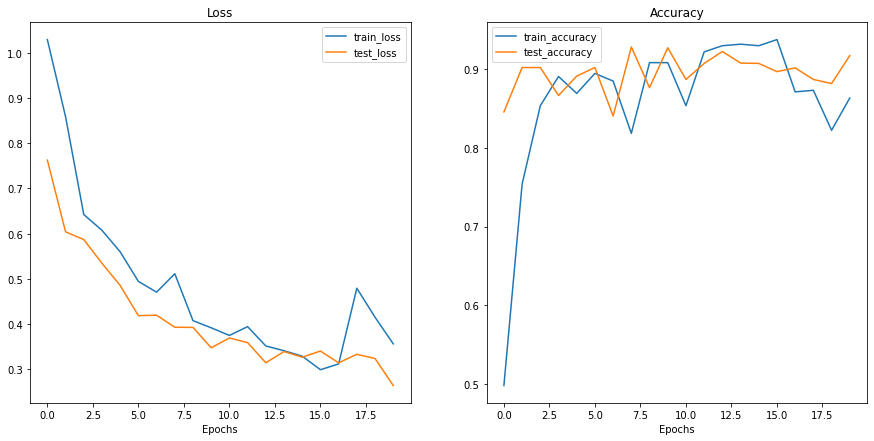

In [48]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
from helper_functions import plot_loss_curves


# Plot the loss curves of our model
plot_loss_curves(results)

# 6. Make predictions on images from the test set

In [49]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

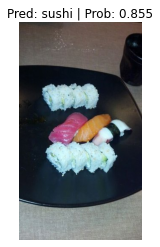

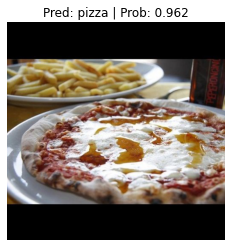

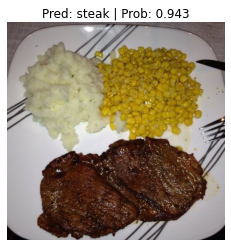

In [53]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

## 6.1 Making predictions on a custom image
It looks like our model does well qualitatively on data from the test set.

But how about on our own custom image?

That's where the real fun of machine learning is!

Predicting on your own custom data, outisde of any training or test set.

To test our model on a custom image, let's import the old faithful pizza-dad.jpeg image (an image of my dad eating pizza).

We'll then pass it to the pred_and_plot_image() function we created above and see what happens.

data/04-pizza-dad.jpeg already exists, skipping download.


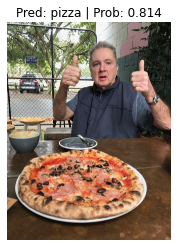

In [54]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)